# Random Forest vs Gradient Boosting

The bias-variance tradeoff is a challange in machine learning which states that models with low bias will usually have high variance and vice versa.

**Bias** is the difference between the actual value and the expected value predicted by the model. A model with a high bias is said to be oversimplified as a result, underfitting the data.

**Variance**, on the other hand, represents a model’s sensitivity to small fluctuations in the training data. A model with high variance is sensitive to noise and as a result, overfitting the data. In other words, the model fits well on training data but fails to generalise on unseen (testing) data.

![title](img/Bias_Variance.png)

![title](img/Bias_Variance1.png)

It is very common that the individual model suffers from bias or variances and that’s why we need the ensemble learning.

Ensemble learning, in general, is a model that makes predictions based on a number of different models. By combining individual models, the ensemble model tends to be more flexible (less bias) and less data-sensitive (less variance).

Two most popular ensemble methods are bagging and boosting.
1. Bagging: Training a bunch of individual models in a parallel way. Each model is trained by a random subset of the data
2. Boosting: Training a bunch of individual models in a sequential way. Each individual model learns from mistakes made by the previous model.

![title](img/RF_GB1.png)

### Random Forest

Random forest is an ensemble model using bagging as the ensemble method and decision tree as the individual model.

![title](img/RF_GB2.png)

Step 1: Select n (e.g. 1000) random subsets from the training set

Step 2: Train n (e.g. 1000) decision trees
- one random subset is used to train one decision tree
- the optimal splits for each decision tree are based on a random subset of features (e.g. 10 features in total, randomly select 5 out of 10 features to split)

Step 3: Each individual tree predicts the records/candidates in the test set, independently.

Step 4: Make the final prediction

For each candidate in the test set, Random Forest uses the class (e.g. cat or dog) with the majority vote as this candidate’s final prediction.

### Gradient Boosting

Gradient Boosting learns from the mistake — residual error directly, rather than update the weights of data points.

![title](img/RF_GB3.png)

Step 1: Train a decision tree

Step 2: Apply the decision tree just trained to predict

Step 3: Calculate the residual of this decision tree, Save residual errors as the new y

Step 4: Repeat Step 1 (until the number of trees we set to train is reached)

Step 5: Make the final prediction

The Gradient Boosting makes a new prediction by simply adding up the predictions (of all trees).

![title](img/RF_GB4.png)

### Implementation in Python Sklearn

Here is a simple implementation of those two methods explained above in Python Sklearn using Titanic dataset.

In [1]:
# Read files
#import os

# Data wrangling and data visualisation 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix

# Others
import time
#import warnings
#warnings.filterwarnings("ignore")

### Import and Load Data

In [2]:
# Read data from the file
data = pd.read_csv("Titanic_train.csv")
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


### Feature engineering and preprocessing

- Fill missing data in the **Age** column with average age
- Combine **SibSp** and **Parch** features into a single feature: **family_size**
- Create indicator for missing data in the **Cabin** column: **cabin_missing**
- Encode the **Sex** column by assigning 0: male and 1: female
- Drop **SibSp, Parch, PassengerId, Cabin, Embarked, Name** and **Ticket** columns
- Train test split (80% training set and 20% test set)

In [3]:
# Missing data 
total = len(data)
missing_data = data.isnull().sum()
missing_data = missing_data[missing_data > 0]
missing_data
pd.DataFrame({"# Missing": missing_data, "% Missing": round(missing_data / len(data) * 100, 2)})

,# Missing,% Missing
Age,177,19.87
Cabin,687,77.10
Embarked,2,0.22


In [4]:
# Fill missing data in Age column
data['Age'].fillna(data['Age'].mean(), inplace = True)

<Figure size 432x288 with 0 Axes>

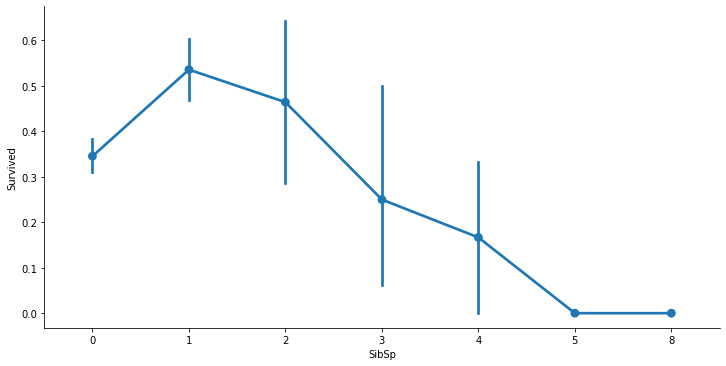

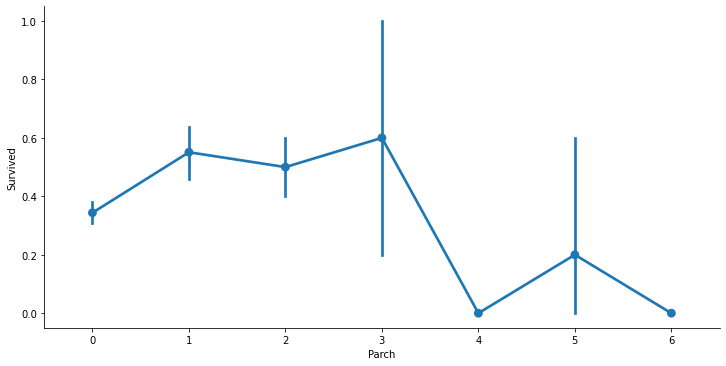

In [5]:
# Survival probability by SibSp and Parch 
# SibSp is the number of siblings or spouse of a person onboard.
# SibSp is the number of parents or children each passenger was touring with
for i, col in enumerate(['SibSp', 'Parch']):
    plt.figure(i)
    sns.catplot(x = col, y = 'Survived', data = data, kind = 'point', aspect = 2)

In [6]:
# Combine SibSp and Parch into a single feature family_size 
data['family_size'] = data['SibSp'] + data['Parch']
data[['SibSp', 'Parch', 'family_size']].head(10)

,SibSp,Parch,family_size
0,1,0,1
1,1,0,1
2,0,0,0
3,1,0,1
4,0,0,0
5,0,0,0
6,0,0,0
7,3,1,4
8,0,2,2
9,1,0,1


To prevent multicollinearity issues, we need to remove SibSp and Parch features.

In [7]:
# Drop SibSp, Parch and PassengerId features
data = data.drop(['SibSp', 'Parch', 'PassengerId'], axis = 1)
data.head()

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,family_size
0,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,NaN,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C85,C,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,NaN,S,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,C123,S,1
4,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,NaN,S,0


In [8]:
# 1: Cabin is missing, 0: Cabin is not missing 
data['cabin_missing'] = np.where(data['Cabin'].isnull(), 1, 0)
data[['Cabin', 'cabin_missing']].head()

,Cabin,cabin_missing
0,NaN,1
1,C85,0
2,NaN,1
3,C123,0
4,NaN,1


In [9]:
# Encode Sex 0: male, 1: female
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})
data.head()

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,family_size,cabin_missing
0,0,3,"Braund, Mr. Owen Harris",0,22.0,A/5 21171,7.2500,NaN,S,1,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,PC 17599,71.2833,C85,C,1,0
2,1,3,"Heikkinen, Miss. Laina",1,26.0,STON/O2. 3101282,7.9250,NaN,S,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,113803,53.1000,C123,S,1,0
4,0,3,"Allen, Mr. William Henry",0,35.0,373450,8.0500,NaN,S,0,1


In [10]:
# Drop Cabin, Embarked, Name and Ticket columns
data = data.drop(['Cabin', 'Embarked', 'Name', 'Ticket'], axis = 1)
data.head()

,Survived,Pclass,Sex,Age,Fare,family_size,cabin_missing
0,0,3,0,22.0,7.2500,1,1
1,1,1,1,38.0,71.2833,1,0
2,1,3,1,26.0,7.9250,0,1
3,1,1,1,35.0,53.1000,1,0
4,0,3,0,35.0,8.0500,0,1


In [11]:
# Separate features and target variables
features = data.drop('Survived', axis = 1)
target = data['Survived']

# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size = 0.2, random_state = 42)

# Check shape (rows, columns)
print(f"Original data: {data.shape}")
print(f"X_train: {X_train.shape}")
print(f"Y_train: {Y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"Y_test: {Y_test.shape}")

Original data: (891, 7)
X_train: (712, 6)
Y_train: (712,)
X_test: (179, 6)
Y_test: (179,)


### Random Forest

Default hyperparameters for RandomForestClassifier 

`RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
)`

In [12]:
# GridSearchCV for RandomForestClassifier
rf = RandomForestClassifier(n_jobs = -1, random_state = 10)
params = {
            'n_estimators': [5, 50, 250],
            'max_depth': [2, 4, 8, 16, 32, None]
        }

cv = GridSearchCV(rf, params, cv = 5, n_jobs = -1)
cv.fit(X_train, Y_train)
pd.DataFrame(cv.cv_results_).sort_values('mean_test_score', ascending = False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.155800,0.034026,0.021201,0.002482,4,50,"{'max_depth': 4, 'n_estimators': 50}",0.832168,0.846154,0.816901,0.802817,0.845070,0.828622,0.016696,1
6,0.027400,0.005851,0.013400,0.002416,8,5,"{'max_depth': 8, 'n_estimators': 5}",0.818182,0.839161,0.802817,0.838028,0.823944,0.824426,0.013478,2
7,0.139200,0.015211,0.043801,0.012220,8,50,"{'max_depth': 8, 'n_estimators': 50}",0.832168,0.825175,0.795775,0.816901,0.845070,0.823018,0.016458,3
8,0.665402,0.055099,0.076600,0.011741,8,250,"{'max_depth': 8, 'n_estimators': 250}",0.825175,0.825175,0.802817,0.809859,0.830986,0.818802,0.010632,4
10,0.155400,0.020588,0.039200,0.009131,16,50,"{'max_depth': 16, 'n_estimators': 50}",0.825175,0.797203,0.795775,0.823944,0.838028,0.816025,0.016703,5


In [13]:
# Best hyperparameters for RandomForestClassifier 
cv.best_params_

{'max_depth': 4, 'n_estimators': 50}

In [14]:
# Instantiate RandomForestClassifier with best hyperparameters 
rf = RandomForestClassifier(n_estimators = 50, max_depth = 4, n_jobs = -1, random_state = 42)

# Fit model
start = time.time()
rf_model = rf.fit(X_train, Y_train)
end = time.time()
fit_time = end - start

# Predict 
start = time.time()
Y_pred = rf_model.predict(X_test)
end = time.time()
pred_time = end - start

# Time and prediction results
precision, recall, fscore, support = score(Y_test, Y_pred, average = 'binary')
print(f"Fit time: {round(fit_time, 3)} / Predict time: {round(pred_time, 3)}")
print(f"Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / Accuracy: {round((Y_pred==Y_test).sum() / len(Y_pred), 3)}")

Fit time: 0.079 / Predict time: 0.011
Precision: 0.797 / Recall: 0.689 / Accuracy: 0.799


<AxesSubplot:>

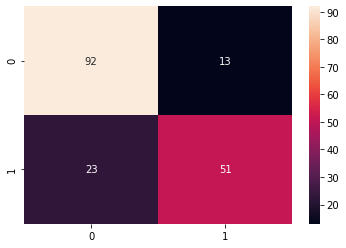

In [15]:
# Confusion matrix for RandomForestClassifier
matrix = confusion_matrix(Y_test, Y_pred)
sns.heatmap(matrix, annot = True, fmt = 'd')

### Gradient Boosting

Default hyperparameters for GradientBoostingClassifier

`GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)`

In [16]:
# GridSearchCV for GradientBoostingClassifier 
gb = GradientBoostingClassifier(random_state = 10)
params = {
        'n_estimators': [5, 50, 250, 500],
        'max_depth': [1, 3, 5, 7, 9],
        'learning_rate': [0.01, 0.1, 1, 10, 100]
        }

cv = GridSearchCV(gb, params, cv = 5, n_jobs = -1)
cv.fit(X_train, Y_train)
pd.DataFrame(cv.cv_results_).sort_values('mean_test_score', ascending = False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,0.351401,0.018051,0.0042,0.000400,0.01,3,250,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.846154,0.839161,0.823944,0.816901,0.802817,0.825795,0.015515,1
10,0.669927,0.039026,0.0050,0.001548,0.01,5,250,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.839161,0.825175,0.802817,0.830986,0.823944,0.824416,0.012066,2
11,1.285287,0.044966,0.0060,0.000633,0.01,5,500,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.832168,0.832168,0.788732,0.830986,0.830986,0.823008,0.017146,3
7,0.650914,0.028077,0.0054,0.001854,0.01,3,500,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.832168,0.839161,0.823944,0.816901,0.802817,0.822998,0.012575,4
26,0.482801,0.037668,0.0048,0.000400,0.1,3,250,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.811189,0.825175,0.802817,0.838028,0.830986,0.821639,0.012899,5


In [17]:
# Best hyperparameters for GradientBoostingClassifier 
cv.best_params_

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250}

In [18]:
# Random Forest Time and prediction results
print("Random Forest Time and prediction results")
precision, recall, fscore, support = score(Y_test, Y_pred, average = 'binary')
print(f"Fit time: {round(fit_time, 3)} / Predict time: {round(pred_time, 3)}")
print(f"Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / Accuracy: {round((Y_pred==Y_test).sum() / len(Y_pred), 3)}")
print("-------------------------------------------------------------------------")

# Instantiate GradientBoostingClassifier with best hyperparameters 
rf = GradientBoostingClassifier(n_estimators = 250, max_depth = 3, learning_rate = 0.01, random_state = 42)

# Fit model
start = time.time()
rf_model = rf.fit(X_train, Y_train)
end = time.time()
fit_time = end - start

# Predict 
start = time.time()
Y_pred = rf_model.predict(X_test)
end = time.time()
pred_time = end - start

# GradientBoosting Time and prediction results
print("GradientBoosting Time and prediction results")
precision, recall, fscore, support = score(Y_test, Y_pred, average = 'binary')
print(f"Fit time: {round(fit_time, 3)} / Predict time: {round(pred_time, 3)}")
print(f"Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / Accuracy: {round((Y_pred==Y_test).sum() / len(Y_pred), 3)}")

Random Forest Time and prediction results
Fit time: 0.079 / Predict time: 0.011
Precision: 0.797 / Recall: 0.689 / Accuracy: 0.799
-------------------------------------------------------------------------
GradientBoosting Time and prediction results
Fit time: 0.22 / Predict time: 0.003
Precision: 0.812 / Recall: 0.703 / Accuracy: 0.81


<AxesSubplot:>

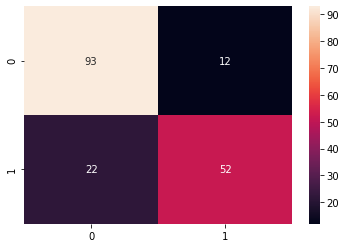

In [19]:
# Confusion matrix for GradientBoostingClassifier
matrix = confusion_matrix(Y_test, Y_pred)
sns.heatmap(matrix, annot = True, fmt = 'd')